In [6]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
from data import MNISTDatamodule, CIFAR10Datamodule, CIFAR100Datamodule, MNIST
from transforms import UnNormalize

In [33]:
from torchvision import transforms as T
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
    ])

unnormalize = UnNormalize(mean=mean, std=std)

In [34]:
dm = CIFAR100Datamodule(
    transform=transform,
    data_dir="./../data"
)

In [35]:
dm.prepare_data()

Files already downloaded and verified
Files already downloaded and verified


In [36]:
dm.setup()

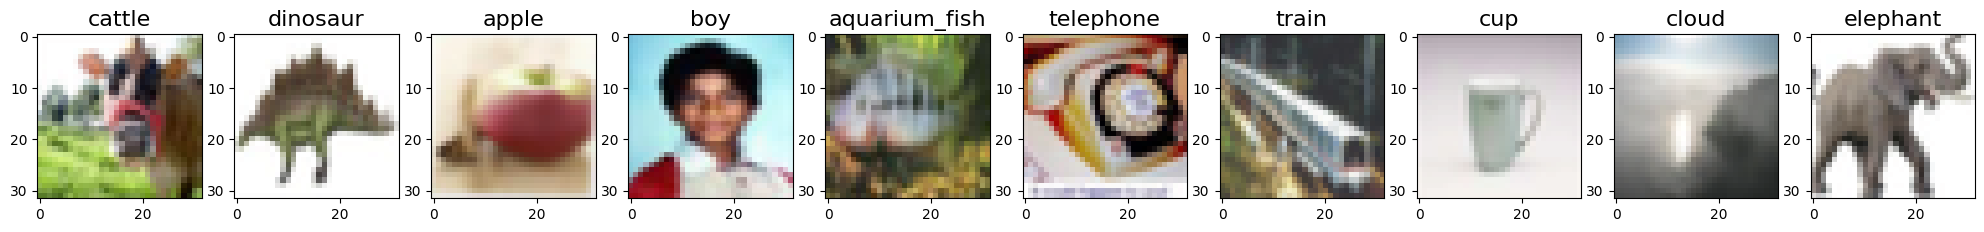

In [39]:
dm.plot_images(split="train", transform=unnormalize)